# What Factors Affect the Ability of a team to win across games

In [85]:
import pandas as pd
from matplotlib import pyplot as plt
# Make sure you have seaborn version 0.9.
import seaborn as sns
from scipy.stats import ttest_ind

## Number of Shutouts by World Series Winner vs. Average Number of Shutouts by Year

Are shutouts a good measure of whether a team may win the World Series? To test this, we will compare the number of shutouts the World Series winner to the average number of shutouts for the year. If the World Series winner has a consistently higher number of shutouts than average, then the number of shutouts a team gets in a season is a good measure of whether they might win the World Series. Otherwise, shutouts will be a bad measure of whether a team might win the World Series.

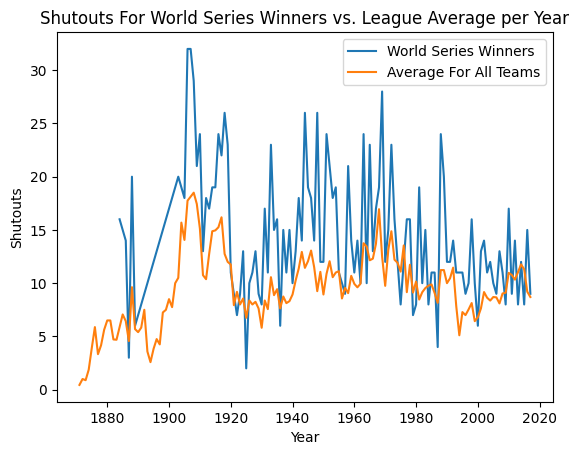

In [93]:
teams = pd.read_csv("./data/core/Teams.csv")
winners = teams[teams.WSWin == 'Y']
sns.lineplot(data=winners, x="yearID", y="SHO", label="World Series Winners")

shutoutsByYear = teams.groupby('yearID').agg({'SHO': 'mean'})
sns.lineplot(data=shutoutsByYear, x="yearID", y="SHO", label="Average For All Teams")
plt.title('Shutouts For World Series Winners vs. League Average per Year')
plt.xlabel('Year')
plt.ylabel('Shutouts')
plt.show()

The diagram produced by the code above shows that the number of shutouts the World Series winner has in a season is typically significantly greater than the average number of shutouts a team gets in a season. It should be noted that this correlation does not necessarily mean that a team who has a lot of shutouts will win the World Series, it just implies that a common feature of World Series winners is having a number of shutouts which is significantly higher than average.

## Stealing Bases vs Win Rate

In baseball, stealing bases is sometimes considered "just showing off", and is not considered very meaningful for increasing your chances of winning the game. Is this true? To find out, we will compare the success rate of a team at stealing bases against that team's win rate. If there is a sufficient positive correlation between successful base steals and a team's win rate, then it may be advantageous to steal bases IF your team is good at stealing bases (have a high success rate). We will also compare each team's total number of base stealing attempts to their win rate to determine whether or not trying to steal more bases is a good strategy in general. 

In [87]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

stealTeams = teams[['CS', 'SB', 'G', 'W', 'yearID', 'teamID']]
stealTeams = stealTeams[stealTeams.yearID > 1960] 
stealTeams = stealTeams.dropna()
stealTeams['stealAttempts'] = stealTeams.SB + stealTeams.CS
stealTeams['successfulStealAttemptsPercent'] = stealTeams.SB/stealTeams.stealAttempts
stealTeams['winPercent'] = stealTeams.W/stealTeams.G

Text(20.250000000000007, 0.5, 'Win Rate (%)')

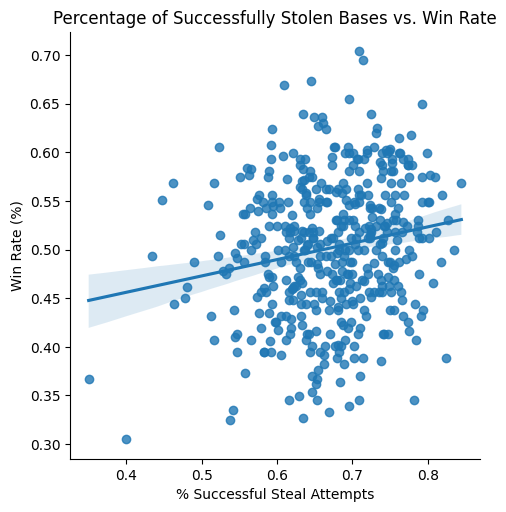

<Figure size 640x480 with 0 Axes>

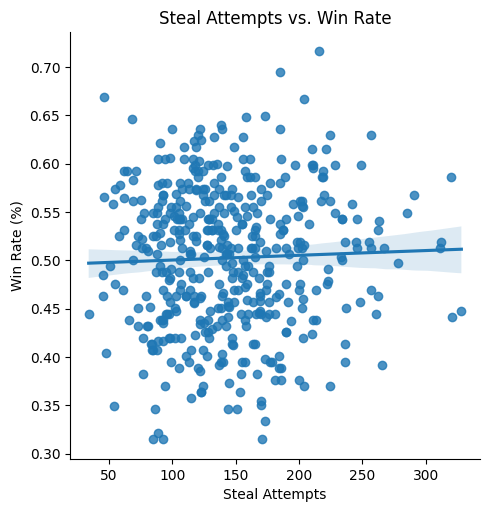

In [92]:
sns.lmplot(x='successfulStealAttemptsPercent', y='winPercent', data=stealTeams.sample(frac=.3))
plt.title('Percentage of Successfully Stolen Bases vs. Win Rate')
plt.xlabel('% Successful Steal Attempts')
plt.ylabel('Win Rate (%)')
plt.figure()
sns.lmplot(x='stealAttempts', y='winPercent', data=stealTeams.sample(frac=.3))
plt.title('Steal Attempts vs. Win Rate')
plt.xlabel('Steal Attempts')
plt.ylabel('Win Rate (%)')

The figure "Percentage of Successfully Stolen Bases vs. Win Rate" above shows that there is a slight positive correlation between successful steals and win rate. This means that if your baseball team has a high success rate when it comes to stealing, then stealing more bases may result in a higher win rate. The figure "Steal Attempts vs. Win Rate" shows that there is not necessarily a positive correlation between steal attempts and win rate. This means that in general trying to steal more bases will not result in a higher win rate, so it is not a good general strategy. However, if you are confident that your team has a high success rate, then it may be a good strategy.

# Home Games versus Win Rate

Does the number of Home Games a team has in a season play a significant influence on their win rate for that season? We will test this by plotting two histograms, one for the win rate of teams who played $>51\%$ of their games at home, and another for the win rate of teams who played $<49\%$ of their games at home. If these two distributions are different, there is a significant chance that the number of games played at home influences the win rate of a team.

'Mean WR for mostly home teams: 0.5080584844557066'

'Median WR for mostly home teams: 0.5158730158730159'

'Mean WR for mostly away teams: 0.4654774435795811'

'Median WR for mostly away teams: 0.460273492286115'

Ttest_indResult(statistic=4.0709959069358925, pvalue=6.320833619441808e-05)

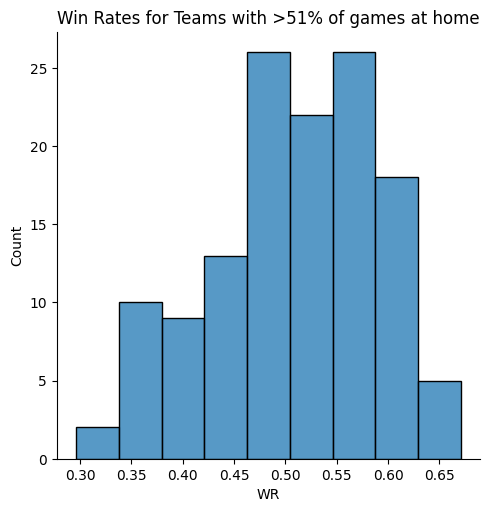

<Figure size 640x480 with 0 Axes>

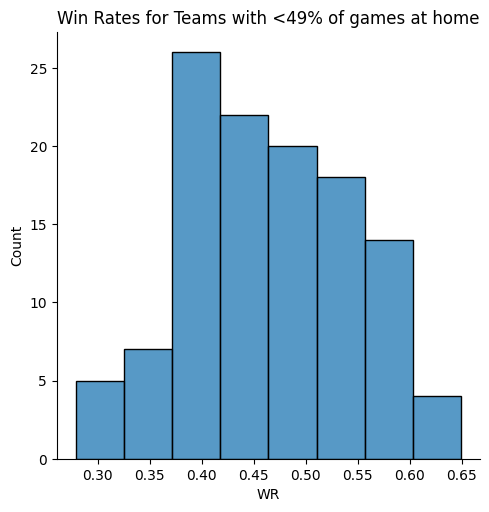

<Figure size 640x480 with 0 Axes>

In [89]:
teams = pd.read_csv('./data/core/Teams.csv')

gameData = teams[['W','L','Ghome','G']]
gameData = gameData.dropna()
# Create Win Rate Column
gameData['WR'] = gameData.W / gameData.G
gameData['homePercent'] = gameData.Ghome / gameData.G

# Teams with a home game % of > 51
mostHome = gameData[gameData.homePercent > 0.51]
sns.displot(data=mostHome, x='WR')
plt.title("Win Rates for Teams with >51% of games at home")
plt.figure()

display(f"Mean WR for mostly home teams: {mostHome.WR.mean()}")
display(f"Median WR for mostly home teams: {mostHome.WR.median()}")


# Teams with a home game % of < 49
mostAway = gameData[gameData.homePercent < 0.49]
sns.displot(data=mostAway, x='WR')
plt.title("Win Rates for Teams with <49% of games at home")
plt.figure()

display(f"Mean WR for mostly away teams: {mostAway.WR.mean()}")
display(f"Median WR for mostly away teams: {mostAway.WR.median()}")

display(ttest_ind(mostHome.WR, mostAway.WR))

The figures above show that teams which play more games at home tend to have a significantly better win rate, with an average win rate of 50.8% and a median win rate of 51.5%, where the teams which play more games away have an average win rate of 46.5% and a median win rate of 46.0%. Conducting a t-test yields a p-value of $6.3*10^{-5}$, meaning that the difference in these two distributions is statistically significant.

# Win Rate versus Rank for AL and NL

There are two leagues, the National League (NL) and the American League (AL). Within those two leagues are the Eastern (E), Central (C), and Western (W) divisions. Rankings are within each division within each league. Plotting the average win rate for each rank for each division, we can determine whether the best team in each division is always ranked the highest. We can also use these plots to compare the National and American leagues.

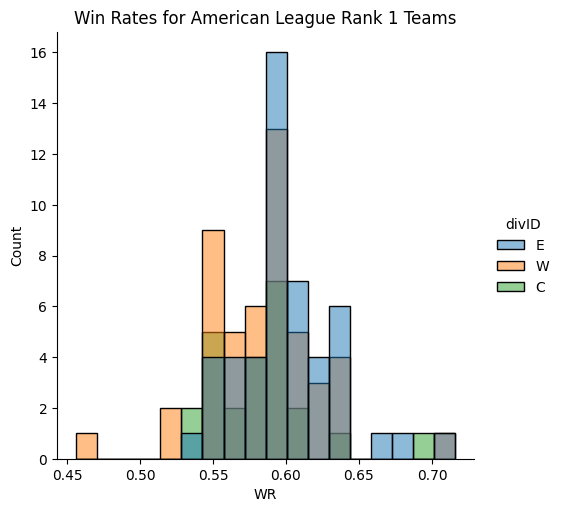

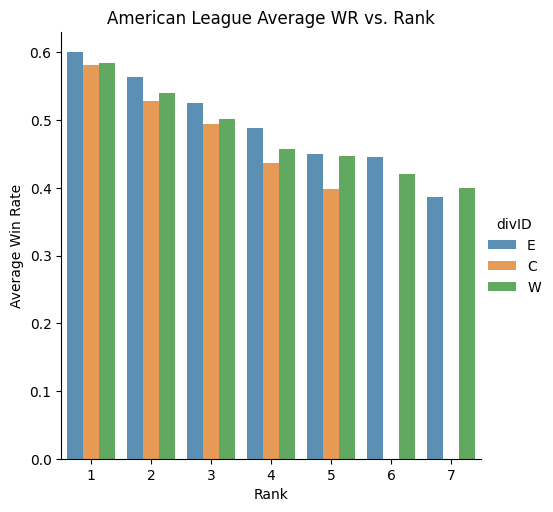

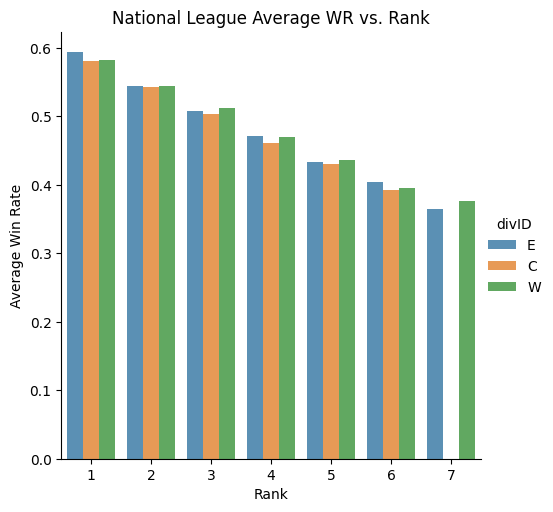

In [90]:
# Code to split teams df into divisions and leagues
teams = pd.read_csv('./data/core/Teams.csv')
teams.dropna()
teams['WR'] = teams.W / teams.G

americanLeague = teams[teams.lgID == "AL"]
nationalLeague = teams[teams.lgID == "NL"]

# Eastern American League, Rank 1 -- Checking if data is more suitable for mean or median
eaLeague = americanLeague[(americanLeague.Rank == 1)]
sns.displot(data=eaLeague, x='WR',hue='divID')
plt.title("Win Rates for American League Rank 1 Teams")

# For each league, compute the average win rate for each rank in each division
aggregation = 'mean'
# aggregation = 'median'
for league in [americanLeague, nationalLeague]:
    east = league[league.divID == 'E'].groupby('Rank').agg({'WR': aggregation,'divID': 'max'}).reset_index()
    central = league[league.divID == 'C'].groupby('Rank').agg({'WR': aggregation, 'divID': 'max'}).reset_index()
    west = league[league.divID == 'W'].groupby('Rank').agg({'WR': aggregation, 'divID': 'max'}).reset_index()
    averages = pd.concat([east, central, west])
    title  = "American League" if league is americanLeague else "National League"
    p = sns.catplot(data=averages, x='Rank', y='WR', hue='divID', kind='bar', alpha=0.8)
    plt.title(title + " Average WR vs. Rank")
    p.set_axis_labels("Rank", "Average Win Rate")
    

For all leagues in both divisions, a better ranking corresponds to a better win rate. However, the American league has a wider range of average win rates between each rank when compared to the National League. Specifically, Eastern teams have a much better average win rate than Western teams, who have better win rates than Central teams. This chasm between average win rates in the American league can be dramatic. For example, the average win rate of teams ranked 6th in the Eastern division is greater than the average win rate of teams ranked 4th in the Central division.  

In contrast, the divisions in the National League have average win rates that are much closer together for each rank. While the Central divison still has the lowest average win rates, the difference is less dramatic. For this reason, we believe that the National League is a more competitive league than the American League. We also believe that in general, Eastern teams have the best chance of winning a game, followed by Western teams, with teams from the Central division having the lowest chance of winning their games.

The same result is found when the median win rate is used instead of the average win rate.